# Solar Power Generation

This notebook demonstrates how to forecast solar power output using weather data from AIFS (AI Integrated Forecasting System) and compare it against climatological averages.

## 1. Imports

In [5]:
from pathlib import Path
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

## 2. Power Plant Configuration

Find a list of power plants at https://openinframap.org/stats/area/Kenya/plants. 

* Garissa Solar Power Station is a solar power plant with a total output of 50 MW.

In [45]:
location_name = "Garissa Solar Power Station"
lat_point = -1.74225
lon_point = 36.66670
output_mw = 50 

## 3. Load Forecast Data

In [14]:

forecast_fn = Path("data/AIFS/output/20251106000000-360h_ssrd.nc")
ds = xr.open_dataset(forecast_fn)

In [15]:
forecast_location = ds['ssrd'].sel(
    latitude=lat_point, 
    longitude=lon_point, 
    method='nearest'
)

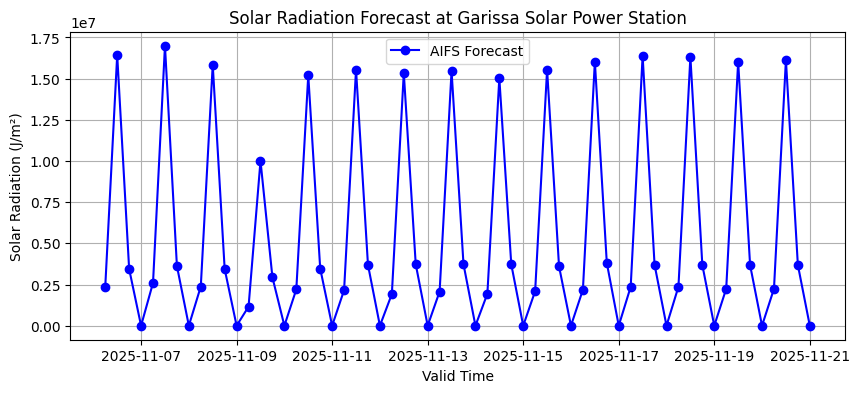

In [19]:
# take the difference to get flux from cumulative
diff = forecast_location.diff("step")

# skip first value which is nan after diff
valid_times = forecast_location.valid_time[1:]

plt.figure(figsize=(10, 4))
plt.plot(valid_times, diff, marker='o', label='AIFS Forecast', color='blue')
plt.title(f'Solar Radiation Forecast at {location_name}')
plt.xlabel('Valid Time')
plt.ylabel('Solar Radiation (J/m²)')
plt.grid()
plt.legend()

In [32]:
 # now get the daily sum from 6h intervals
forecast_sum_daily = diff.groupby("valid_time.day").sum(dim="step")

# skip last day if incomplete
forecast_sum_daily = forecast_sum_daily[:-1]

valid_times_days = pd.date_range(
    start=pd.to_datetime(valid_times.values[0]).replace(hour=0, minute=0, second=0),
    end=pd.to_datetime(valid_times.values[-1]).replace(hour=0, minute=0, second=0),
    freq='D'
)[:-1]



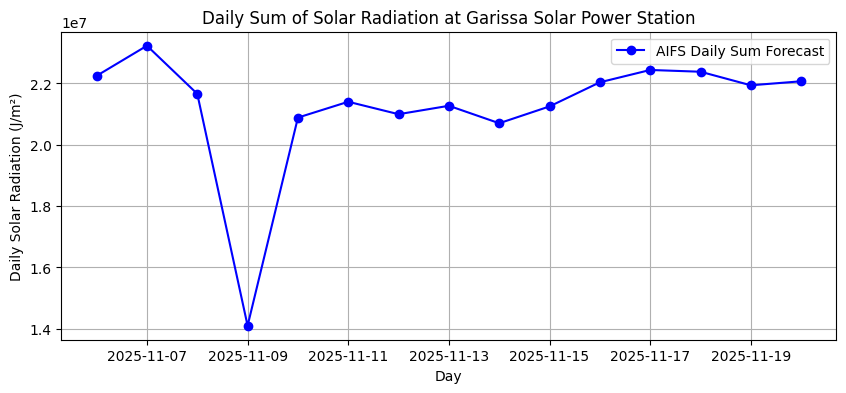

In [35]:
# plot 
plt.figure(figsize=(10, 4))
plt.plot(valid_times_days, forecast_sum_daily, marker='o', label='AIFS Daily Sum Forecast', color='blue')
plt.title(f'Daily Sum of Solar Radiation at {location_name}')
plt.xlabel('Day')
plt.ylabel('Daily Solar Radiation (J/m²)')
plt.grid()
plt.legend()
plt.show()

In [37]:
# open climatology data
climatology_file = Path("data/climatology/surface_solar_radiation_downwards_climatology.nc")
ds_clim = xr.open_dataset(climatology_file)

# Extract forecast at location
clim_location = ds_clim['ssrd'].sel(
    latitude=lat_point, 
    longitude=lon_point, 
    method='nearest'
)

# Extract climatology for forecast period
clim_forecast_period = clim_location.sel(dayofyear=list(valid_times_days.dayofyear))

<xarray.DataArray 'ssrd' (dayofyear: 15)> Size: 60B
[15 values with dtype=float32]
Coordinates:
  * dayofyear  (dayofyear) int64 120B 310 311 312 313 314 ... 321 322 323 324
    number     int64 8B ...
    latitude   float64 8B -1.75
    longitude  float64 8B 36.75
Attributes: (12/32)
    GRIB_paramId:                             169
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      7533
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               J m**-2
    long_name:                                Surface short-wave (solar) radi...
    units:                                    J m**-2
    standard_name:                            surface_downwelling_shortwave_f...
    GRIB_surface:                         

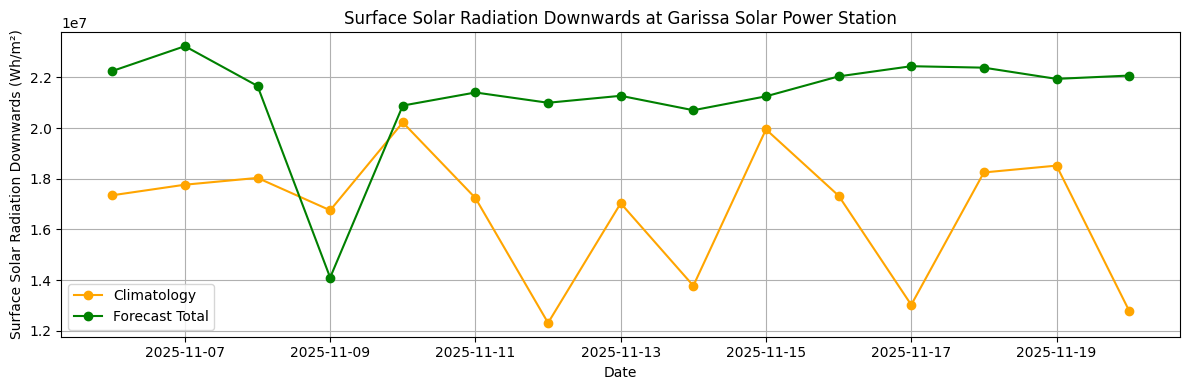

In [43]:
plt.figure(figsize=(12, 4))
plt.plot(valid_times_days, clim_forecast_period*24, marker='o', label='Climatology', color='orange')
plt.plot(valid_times_days, forecast_sum_daily, marker='o', label='Forecast Total', color='green')
plt.title(f'Surface Solar Radiation Downwards at {location_name}')
plt.xlabel('Date')
plt.ylabel('Surface Solar Radiation Downwards (Wh/m²)')
plt.legend()
plt.grid()
plt.tight_layout()

## 4. Solar Power Forecast

Calculate power output based on the ratio of forecasted to climatological solar radiation.

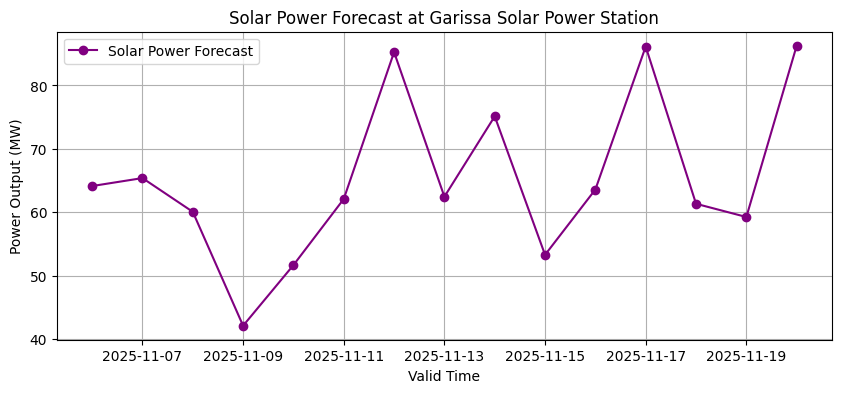

In [56]:
def solar_power(
    GHI: np.ndarray,
    GHI_clim: np.ndarray,
    C_pv: float = 0.2
) -> np.ndarray:
    """
    Simple solar power model.
    Parameters:
    GHI : xarray.DataArray
        the forecasted global horizontal irradiance [W/m²]
    GHI_clim : xarray.DataArray
        the long-term average (climatological) irradiance [W/m²]
    C_pv : float
        the total installed photovoltaic (PV) capacity [MW]
    """
    
    P_pv = C_pv * (GHI / GHI_clim)

    return P_pv


power_forecast = solar_power(
    GHI=forecast_sum_daily.values,  # convert J/m² to W/m
    GHI_clim=(clim_forecast_period*24).values,  # convert J/m² to W/m²
    C_pv=output_mw
)


plt.figure(figsize=(10, 4))
plt.plot(valid_times_days, power_forecast, marker='o', label='Solar Power Forecast',
            color='purple')
plt.title(f'Solar Power Forecast at {location_name}')
plt.xlabel('Valid Time')
plt.ylabel('Power Output (MW)')
plt.grid()
plt.legend()
plt.show()